In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
import xgboost as xgb
from tqdm.auto import tqdm
from sklearn.utils import shuffle
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, label_binarize, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score, r2_score, mean_squared_error,
    accuracy_score, log_loss, confusion_matrix, classification_report,
    mean_absolute_error, explained_variance_score
)
from sklearn.linear_model import (
    LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet,
    BayesianRidge, PassiveAggressiveRegressor
)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier,
    RandomForestRegressor, GradientBoostingRegressor
)
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder

In [2]:
#Load the datafile and print out first few rows in the dataset
df = pd.read_csv('../input/steel-industry-energy-consumption/Steel_industry_data.csv')
df.head() 

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


# Data Cleaning

In [4]:
#Drop the index column
df.reset_index(drop=True, inplace=True) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38544 entries, 0 to 38543
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  38544 non-null  object 
 1   Usage_kWh                             38436 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  38544 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  38544 non-null  float64
 4   CO2(tCO2)                             38544 non-null  float64
 5   Lagging_Current_Power_Factor          38435 non-null  float64
 6   Leading_Current_Power_Factor          38544 non-null  float64
 7   NSM                                   38544 non-null  int64  
 8   WeekStatus                            38544 non-null  object 
 9   Day_of_week                           38544 non-null  object 
 10  Load_Type                             38544 non-null  object 
dtypes: float64(6), 

In [5]:
df.shape

(38544, 11)

In [6]:
# Check for duplicated rows
duplicate_rows = df[df.duplicated()]

# Print the duplicated rows
print("Duplicated Rows:")
print(duplicate_rows)

Duplicated Rows:
                   date  Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
35040  29/04/2018 07:15       2.88                                  3.82   
35041  04/10/2018 12:00      60.77                                 48.02   
35042  26/01/2018 11:30     120.42                                 59.65   
35043  02/06/2018 14:30       3.13                                  0.00   
35044  07/12/2018 15:00      58.86                                 20.99   
...                 ...        ...                                   ...   
38539  22/11/2018 04:00       3.20                                  3.10   
38540  03/01/2018 06:30       4.57                                  4.36   
38541  22/09/2018 08:45       3.31                                  3.17   
38542  11/04/2018 19:15      77.87                                 21.82   
38543  16/02/2018 01:30       3.10                                  3.28   

       Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
35040       

In [7]:
# Removing Duplicates:
df.drop_duplicates(inplace=True)

In [8]:
# Handling Missing Values:
#Check if there is missing value 
df.isnull().sum().sort_values(ascending=False)

Usage_kWh                               101
Lagging_Current_Power_Factor            101
date                                      0
Lagging_Current_Reactive.Power_kVarh      0
Leading_Current_Reactive_Power_kVarh      0
CO2(tCO2)                                 0
Leading_Current_Power_Factor              0
NSM                                       0
WeekStatus                                0
Day_of_week                               0
Load_Type                                 0
dtype: int64

In [9]:
# Drop rows with missing values
df.dropna(inplace=True)

In [10]:
# check nulls after cleaning  
df.isnull().sum().sort_values(ascending=False)

date                                    0
Usage_kWh                               0
Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
WeekStatus                              0
Day_of_week                             0
Load_Type                               0
dtype: int64

In [11]:
df.shape

(34838, 11)

In [12]:
#Summary statistics of the datase
df.describe()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
count,34838.000000,34838.000000,34838.000000,34838.000000,34838.000000,34838.000000,3.483800e+04
mean,27.420703,13.059339,3.855393,0.011591,80.556606,84.421058,5.461265e+04
std,33.420704,16.303616,7.406350,0.016174,18.939339,30.410777,2.592826e+05
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,3.200000,2.300000,0.000000,0.000000,63.200000,99.700000,2.160000e+04
50%,4.570000,5.000000,0.000000,0.000000,87.955000,100.000000,4.320000e+04
75%,51.300000,22.750000,2.020000,0.020000,98.990000,100.000000,6.480000e+04
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,8.550000e+06


In [13]:
df = df.drop(['Leading_Current_Power_Factor'], axis=1)

In [14]:
numeric_cols=[]
for col in df.columns:
    if np.issubdtype(df[col].dtype, np.number):
        numeric_cols.append(col)

In [15]:
#Detect the outliers 
fig = make_subplots(rows=len(numeric_cols), cols=1, subplot_titles=numeric_cols)

for i, feature in enumerate(numeric_cols):
    boxplot = px.box(df, y=feature, title=f'Boxplot of {feature}')
    # Add boxplot to subplots
    for data in boxplot.data:
        fig.add_trace(data, row=i+1, col=1)

fig.update_layout(height=200*len(numeric_cols), showlegend=False)

fig.show() 

In [16]:
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [17]:
def remove_outliers_zscore(df, col):
    mean = df[col].mean()
    std = df[col].std()
    z_scores = (df[col] - mean) / std
    return df[(z_scores > -3) & (z_scores < 3)]

In [18]:
for col in numeric_cols:
    if df[col].skew() > 1 or df[col].skew() < -1:
        df = remove_outliers_iqr(df, col)
    else:
        df = remove_outliers_zscore(df, col)

df.shape

(26312, 10)

In [19]:
#Detect the outliers 
fig = make_subplots(rows=len(numeric_cols), cols=1, subplot_titles=numeric_cols)

for i, feature in enumerate(numeric_cols):
    boxplot = px.box(df, y=feature, title=f'Boxplot of {feature}')
    # Add boxplot to subplots
    for data in boxplot.data:
        fig.add_trace(data, row=i+1, col=1)

fig.update_layout(height=200*len(numeric_cols), showlegend=False)

fig.show() 

# Data Analysis & Visualizations

In [20]:
df.nunique()

date                                    26312
Usage_kWh                                2758
Lagging_Current_Reactive.Power_kVarh     1430
Leading_Current_Reactive_Power_kVarh      221
CO2(tCO2)                                   6
Lagging_Current_Power_Factor             5035
NSM                                        97
WeekStatus                                  2
Day_of_week                                 7
Load_Type                                   3
dtype: int64

In [21]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')

In [22]:
df

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,2018-01-01 00:15:00,3.17,2.95,0.00,0.0,73.21,900,Weekday,Monday,Light_Load
1,2018-01-01 00:30:00,4.00,4.46,0.00,0.0,66.77,1800,Weekday,Monday,Light_Load
2,2018-01-01 00:45:00,3.24,3.28,0.00,0.0,70.28,2700,Weekday,Monday,Light_Load
3,2018-01-01 01:00:00,3.31,3.56,0.00,0.0,68.09,3600,Weekday,Monday,Light_Load
4,2018-01-01 01:15:00,3.82,4.50,0.00,0.0,64.72,4500,Weekday,Monday,Light_Load
...,...,...,...,...,...,...,...,...,...,...
35035,2018-12-31 23:00:00,3.85,4.86,0.00,0.0,62.10,82800,Weekday,Monday,Light_Load
35036,2018-12-31 23:15:00,3.74,3.74,0.00,0.0,70.71,83700,Weekday,Monday,Light_Load
35037,2018-12-31 23:30:00,3.78,3.17,0.07,0.0,76.62,84600,Weekday,Monday,Light_Load
35038,2018-12-31 23:45:00,3.78,3.06,0.11,0.0,77.72,85500,Weekday,Monday,Light_Load


In [23]:
 #Summary statistics of the datase
df.describe()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,NSM
count,26312,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000
mean,2018-07-03 16:15:42.516722432,29.320309,14.199309,0.338517,0.012616,75.116529,37868.615081
min,2018-01-01 00:00:00,2.450000,0.000000,0.000000,0.000000,36.940000,0.000000
25%,2018-04-04 13:41:15,3.170000,4.280000,0.000000,0.000000,57.327500,16200.000000
50%,2018-07-04 09:45:00,4.750000,5.690000,0.000000,0.000000,78.950000,33300.000000
75%,2018-10-02 13:18:45,54.400000,25.160000,0.000000,0.020000,91.950000,59400.000000
max,2018-12-31 23:45:00,119.950000,51.440000,7.920000,0.050000,100.000000,90000.000000
std,NaN,31.654220,13.960715,1.208816,0.015361,18.472215,25414.832135


In [24]:
cf.go_offline()

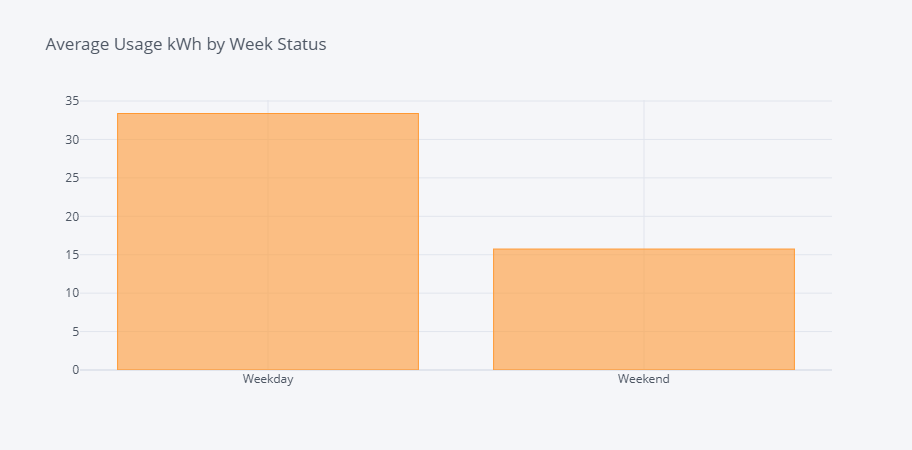

In [25]:
# Bar Plot
df[['WeekStatus', 'Usage_kWh']].groupby('WeekStatus').mean().iplot(kind='bar', title='Average Usage kWh by Week Status')

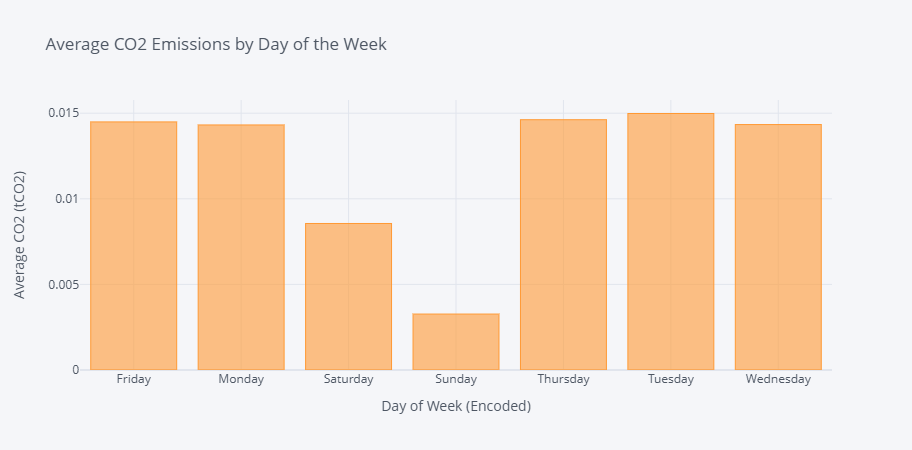

In [26]:
avg_co2_by_day = df.groupby('Day_of_week')['CO2(tCO2)'].mean()
avg_co2_by_day.iplot(kind='bar', title='Average CO2 Emissions by Day of the Week', xTitle='Day of Week (Encoded)', yTitle='Average CO2 (tCO2)')

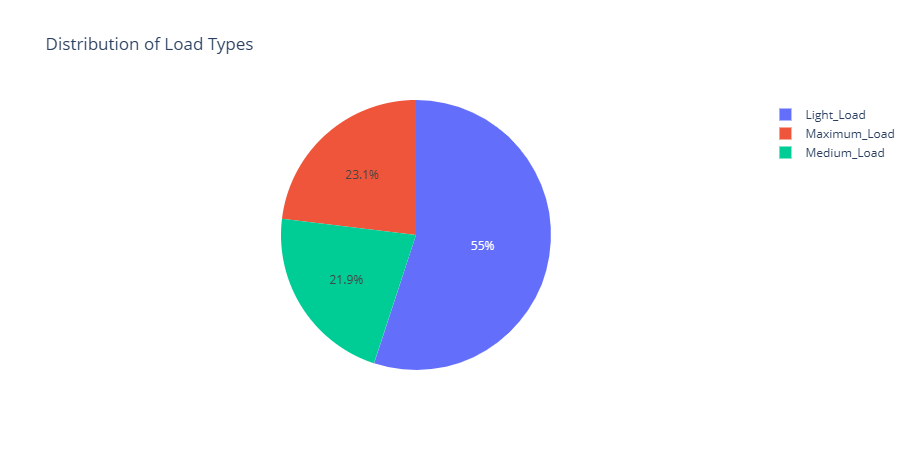

In [27]:
# Count the occurrences of each load type
load_type_counts = df['Load_Type'].value_counts()

# Create the pie chart
fig = go.Figure(data=[go.Pie(labels=load_type_counts.index, values=load_type_counts.values)])
fig.update_layout(title='Distribution of Load Types')
fig.show()

In [28]:
# Identify non-numeric columns
non_numeric_columns = df.select_dtypes(exclude=['float', 'int']).columns

# Drop non-numeric columns
numeric_df = df.drop(columns=non_numeric_columns) 

# Compute correlation matrix
correlation_matrix = numeric_df.corr()  

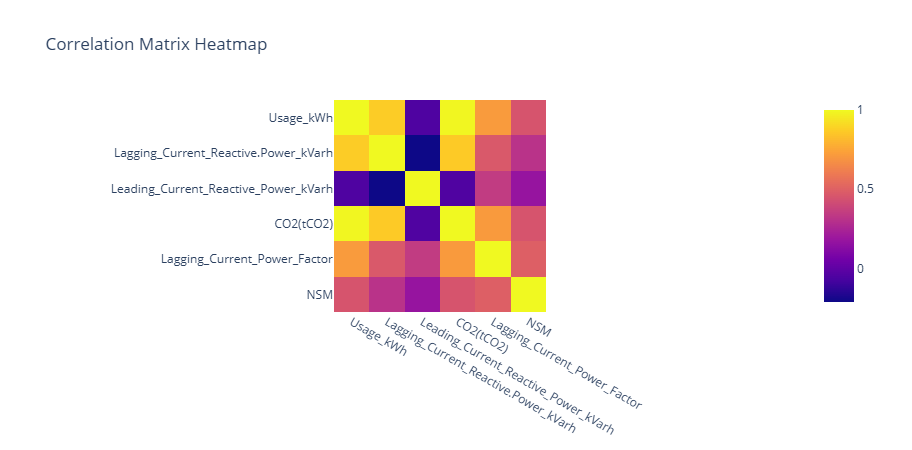

In [29]:
# Create a heatmap
fig = px.imshow(correlation_matrix,
                text_auto=True,
                x=correlation_matrix.columns,
                y=correlation_matrix.columns,
                title="Correlation Matrix Heatmap")
fig.show()

# Data Prepration for Models

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26312 entries, 0 to 35039
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  26312 non-null  datetime64[ns]
 1   Usage_kWh                             26312 non-null  float64       
 2   Lagging_Current_Reactive.Power_kVarh  26312 non-null  float64       
 3   Leading_Current_Reactive_Power_kVarh  26312 non-null  float64       
 4   CO2(tCO2)                             26312 non-null  float64       
 5   Lagging_Current_Power_Factor          26312 non-null  float64       
 6   NSM                                   26312 non-null  int64         
 7   WeekStatus                            26312 non-null  object        
 8   Day_of_week                           26312 non-null  object        
 9   Load_Type                             26312 non-null  object        
dtypes: 

In [31]:
#count the value for load type 
df["Load_Type"].value_counts()

Load_Type
Light_Load      14484
Maximum_Load     6073
Medium_Load      5755
Name: count, dtype: int64

In [32]:
# Data Transformation:
# Encode Categorical Columns
categ = df.select_dtypes(include = "object").columns

columns_to_convert = ['NSM']
df[columns_to_convert] = df[columns_to_convert].astype(float)

le = LabelEncoder()
df[categ] = df[categ].apply(le.fit_transform)

In [33]:
#count the value for load type after LabelEncoder
df["Load_Type"].value_counts()

Load_Type
0    14484
1     6073
2     5755
Name: count, dtype: int64

By checking the value we can see that

0 = Light Load

2 = Medium Load

1 = Maximum Load

In [34]:
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,900.0,0,1,0
1,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,1800.0,0,1,0
2,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,2700.0,0,1,0
3,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,3600.0,0,1,0
4,2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,4500.0,0,1,0


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26312 entries, 0 to 35039
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  26312 non-null  datetime64[ns]
 1   Usage_kWh                             26312 non-null  float64       
 2   Lagging_Current_Reactive.Power_kVarh  26312 non-null  float64       
 3   Leading_Current_Reactive_Power_kVarh  26312 non-null  float64       
 4   CO2(tCO2)                             26312 non-null  float64       
 5   Lagging_Current_Power_Factor          26312 non-null  float64       
 6   NSM                                   26312 non-null  float64       
 7   WeekStatus                            26312 non-null  int64         
 8   Day_of_week                           26312 non-null  int64         
 9   Load_Type                             26312 non-null  int64         
dtypes: 

In [36]:
df = df.drop('date', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26312 entries, 0 to 35039
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Usage_kWh                             26312 non-null  float64
 1   Lagging_Current_Reactive.Power_kVarh  26312 non-null  float64
 2   Leading_Current_Reactive_Power_kVarh  26312 non-null  float64
 3   CO2(tCO2)                             26312 non-null  float64
 4   Lagging_Current_Power_Factor          26312 non-null  float64
 5   NSM                                   26312 non-null  float64
 6   WeekStatus                            26312 non-null  int64  
 7   Day_of_week                           26312 non-null  int64  
 8   Load_Type                             26312 non-null  int64  
dtypes: float64(6), int64(3)
memory usage: 2.0 MB


In [37]:
# Data Augmentation
# Apply random noise
noisy_df = df.apply(lambda x: x + np.random.normal(0, 0.01, len(x)) if x.dtype == 'float' else x)

# Duplicate and shuffle
duplicated_df = pd.concat([df] * 2, ignore_index=True)
shuffled_df = shuffle(duplicated_df)

# Apply SMOTE
X = df.drop('Load_Type', axis=1)
y = df['Load_Type']

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

X_resampled['Load_Type'] = y_resampled
df_aug = X_resampled
df_aug.head()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,3.17,2.95,0.0,0.0,73.21,900.0,0,1,0
1,4.00,4.46,0.0,0.0,66.77,1800.0,0,1,0
2,3.24,3.28,0.0,0.0,70.28,2700.0,0,1,0
3,3.31,3.56,0.0,0.0,68.09,3600.0,0,1,0
4,3.82,4.50,0.0,0.0,64.72,4500.0,0,1,0


In [38]:
df_aug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43452 entries, 0 to 43451
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Usage_kWh                             43452 non-null  float64
 1   Lagging_Current_Reactive.Power_kVarh  43452 non-null  float64
 2   Leading_Current_Reactive_Power_kVarh  43452 non-null  float64
 3   CO2(tCO2)                             43452 non-null  float64
 4   Lagging_Current_Power_Factor          43452 non-null  float64
 5   NSM                                   43452 non-null  float64
 6   WeekStatus                            43452 non-null  int64  
 7   Day_of_week                           43452 non-null  int64  
 8   Load_Type                             43452 non-null  int64  
dtypes: float64(6), int64(3)
memory usage: 3.0 MB


In [39]:
#count the value for load type after data augmentstion
df_aug["Load_Type"].value_counts()

Load_Type
0    14484
2    14484
1    14484
Name: count, dtype: int64

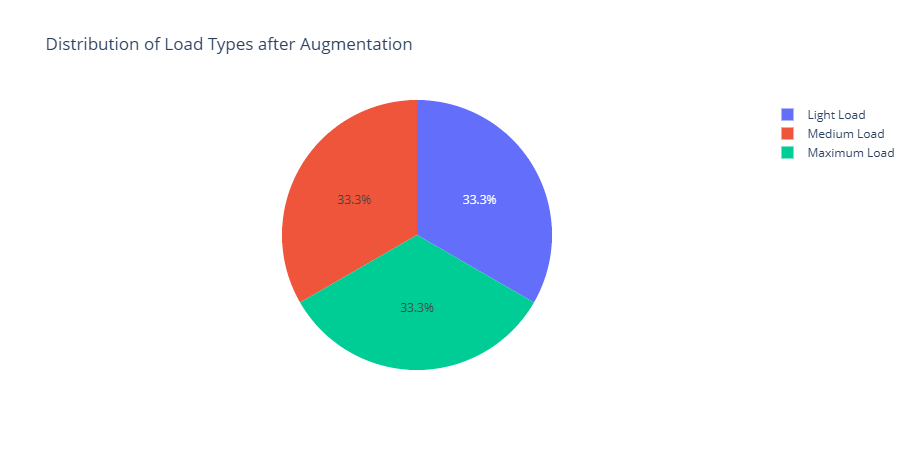

In [40]:
# Count the occurrences of each load type 
load_type_counts = df_aug['Load_Type'].value_counts()

labals_lis = ['Light Load',
              'Medium Load',
              'Maximum Load' ]

# Create the pie chart
fig = go.Figure(data=[go.Pie(labels=labals_lis, values=load_type_counts.values)])
fig.update_layout(title='Distribution of Load Types after Augmentation')
fig.show()

# Classification Models

### Feature Engineering

In [41]:
def feature_selection_using_RF(x,y):
    model = RandomForestClassifier()
    rfe = RFE(model, n_features_to_select=5)  # Choose the number of features to select
    rfe.fit(x, y)

    selected_features = x.columns[rfe.support_]
    importances = np.max(rfe.ranking_) + 1 - rfe.ranking_
    fig = px.bar(x=x.columns, y=importances, labels={'x': 'Feature', 'y': 'Importance'},
                     title='Feature Importances')
    fig.show()
    x = x[selected_features]
    return x,y

In [42]:
def dimensionality_reduction_with_pca(x):
    # Applying PCA
    pca = PCA(n_components=3) # n_components=3
    pca_components = pca.fit_transform(x)
    x = pd.DataFrame(pca_components, columns=['PC1', 'PC2','PC3'])

    # Plotting the explained variance
    explained_var = pca.explained_variance_ratio_
    cumulative_var = explained_var.cumsum()
    total_var = pca.explained_variance_ratio_.sum() * 100

    fig = px.area(
        x=range(1, len(cumulative_var)+1),
        y=cumulative_var,
        labels={"x": "Number of Components", "y": "Cumulative Explained Variance"},
        title=f"PCA Explained Variance Plot {total_var}"
    )
    fig.show()
    return x

In [43]:
x = df.drop(['Load_Type'], axis=1)
y = df.Load_Type

In [44]:
xg = df_aug.drop(['Load_Type'], axis=1)
yg = df_aug.Load_Type

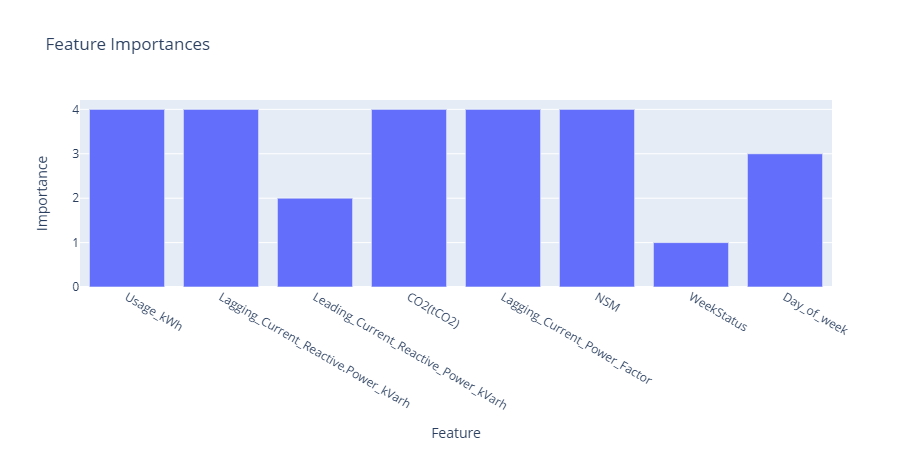

In [45]:
x , y = feature_selection_using_RF(x,y)

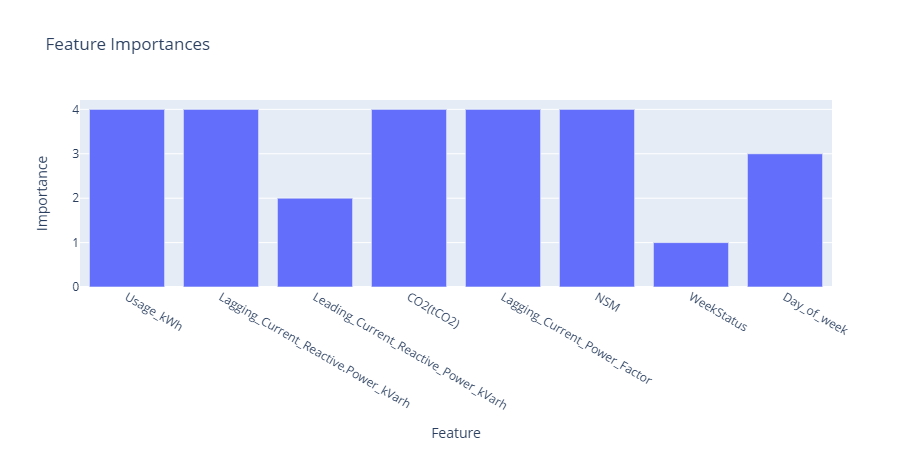

In [46]:
xg , yg = feature_selection_using_RF(xg,yg)

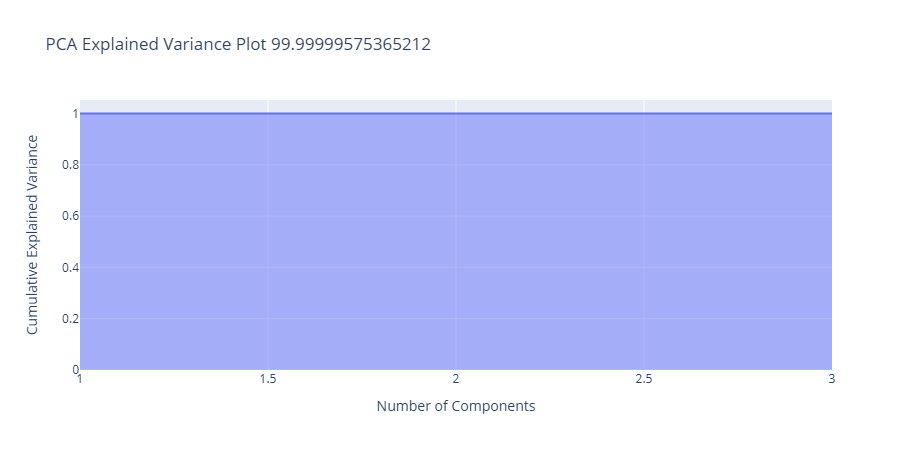

In [47]:
x = dimensionality_reduction_with_pca(x)

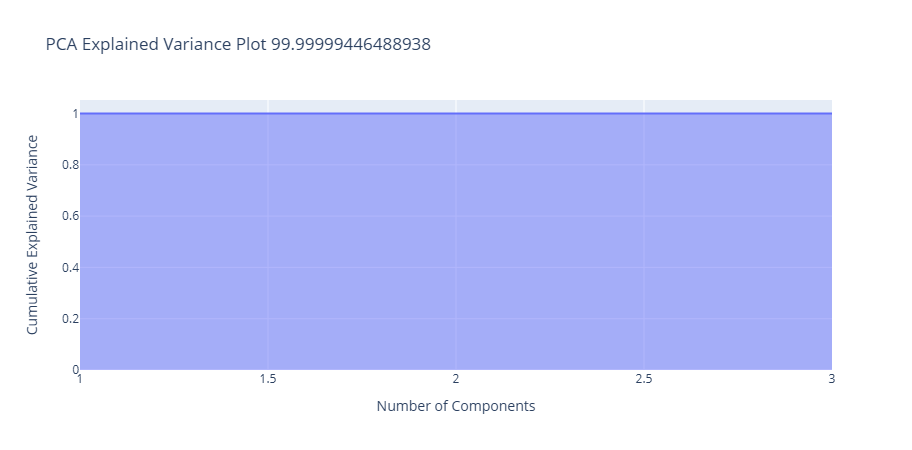

In [48]:
xg = dimensionality_reduction_with_pca(xg)

In [49]:
# Split the dataset and prepare some lists to store the models
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 42) 
xg_train, xg_test, yg_train, yg_test = train_test_split(xg, yg, test_size=0.25, random_state = 42)

### Model Training

In [50]:
#Loop for the training model 
models = []
 
names = [
    "Logistic Regression",
    "KNN",
    "Decision Tree",
    "Naive Bayes",
    "Random Forest",
    "Random Forest with Extra Trees",
    "AdaBoost",
    "XGBoost"
]
 
clf = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    GaussianNB(),
    RandomForestClassifier(n_estimators=200, max_leaf_nodes=16),
    ExtraTreesClassifier(),
    AdaBoostClassifier(DecisionTreeClassifier(max_depth=3)),
    xgb.XGBClassifier()
]

In [51]:
def train_clf(x_train, y_train,x_test, y_test):
    scores = []
    for model in tqdm(clf):
        model.fit(x_train, y_train)
        score = model.score(x_test, y_test)
        scores.append(score)
#         print(model)
#         print(score)
    return pd.DataFrame(zip(names,scores), columns=['Classifier', 'Accuracy'])

  0%|          | 0/8 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



                       Classifier  Accuracy
7                         XGBoost  0.902402
4                   Random Forest  0.898297
5  Random Forest with Extra Trees  0.897081
1                             KNN  0.891608
2                   Decision Tree  0.888264
6                        AdaBoost  0.834752
3                     Naive Bayes  0.777288
0             Logistic Regression  0.760261


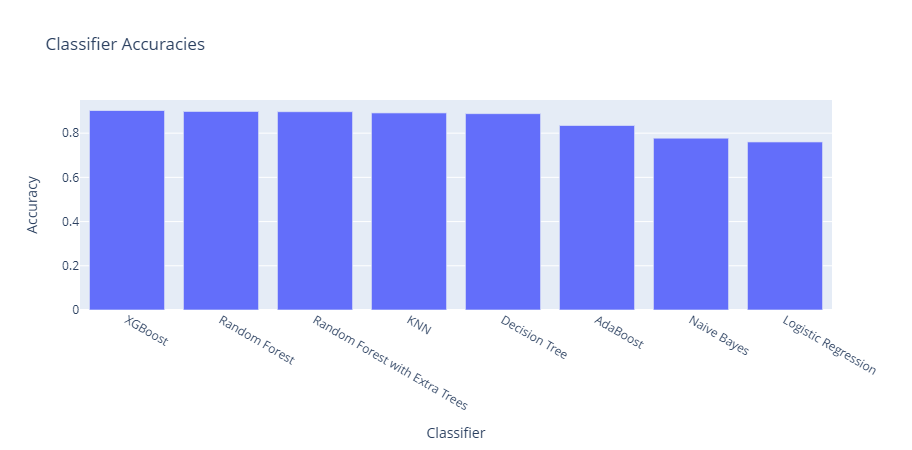

In [52]:
#List the classifier and their accuracy
scores_df = train_clf(x_train, y_train,x_test, y_test)
scores_df = scores_df.sort_values(by=['Accuracy'], ascending=[False])
print(scores_df)

# Plot the accuracies using Plotly Express
fig = px.bar(scores_df, x='Classifier', y='Accuracy', labels={'Classifier': 'Classifier', 'Accuracy': 'Accuracy'},
             title='Classifier Accuracies')
fig.update_layout(xaxis_title='Classifier', yaxis_title='Accuracy')
fig.show()

  0%|          | 0/8 [00:00<?, ?it/s]

                       Classifier  Accuracy
7                         XGBoost  0.902402
4                   Random Forest  0.898297
5  Random Forest with Extra Trees  0.897081
1                             KNN  0.891608
2                   Decision Tree  0.888264
6                        AdaBoost  0.834752
3                     Naive Bayes  0.777288
0             Logistic Regression  0.760261


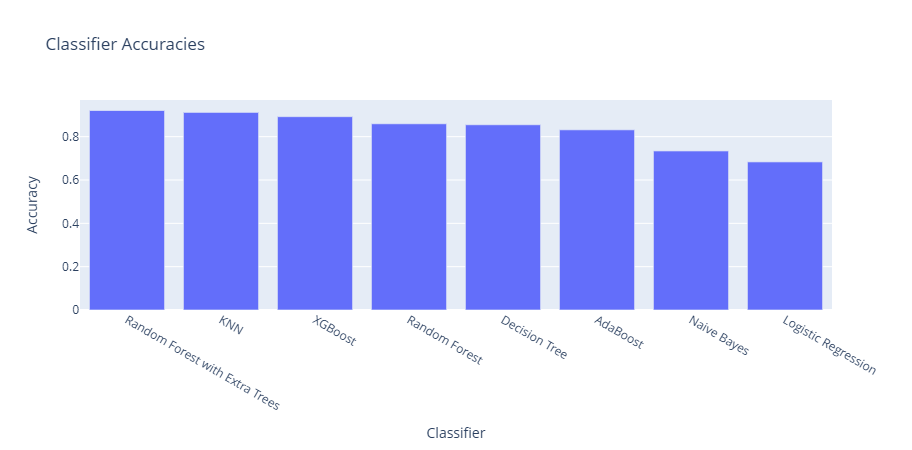

In [53]:
#List the classifier and their accuracy
scores_df_aug = train_clf(xg_train, yg_train,xg_test, yg_test)
scores_df_aug = scores_df_aug.sort_values(by=['Accuracy'], ascending=[False])
print(scores_df)

# Plot the accuracies using Plotly Express
fig = px.bar(scores_df_aug, x='Classifier', y='Accuracy', labels={'Classifier': 'Classifier', 'Accuracy': 'Accuracy'},
             title='Classifier Accuracies')
fig.update_layout(xaxis_title='Classifier', yaxis_title='Accuracy')
fig.show()

In [54]:
#Naive grid search implementation
parameters = {'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]}
CBC = xgb.XGBClassifier()
Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 2, n_jobs=-1)
Grid_CBC.fit(xg_train, yg_train)

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)})

In [55]:
print("Results from Grid Search" )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

Results from Grid Search

 The best estimator across ALL searched params:
 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=180, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

 The best score across ALL searched params:
 0.8888888558289151

 The best parameters across ALL searched params:
 {'learning_rate': 0.1, 'max_depth': 9, 'n_estim

In [56]:
#This is the classification model with the best parameters
Grid_CBC

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)})

In [57]:
# Make predictions on the test set
yg_pred = Grid_CBC.predict(xg_test)

### Model Evaluation

In [58]:
# Calculate evaluation metrics
def cls_report(y_test, y_pred):
    y_test_binarized = label_binarize(y_test, classes=[0, 1, 2]) 
    n_classes = y_test_binarized.shape[1]
    y_pred_reshaped = y_pred.reshape(-1, 1)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test_binarized, y_pred_reshaped)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return class_report, conf_matrix, roc_auc, mse, r2

In [59]:
class_report, conf_matrix, roc_auc, mse, r2 = cls_report(yg_test, yg_pred)

AUC-ROC: 0.0119
Mean Squared Error: 0.11718678081561262
R-squared: 0.8244187290223879

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3672
           1       0.85      0.87      0.86      3612
           2       0.86      0.84      0.85      3579

    accuracy                           0.90     10863
   macro avg       0.90      0.90      0.90     10863
weighted avg       0.90      0.90      0.90     10863

Confusion Matrix:
[[3618    7   47]
 [   6 3149  457]
 [  19  539 3021]]


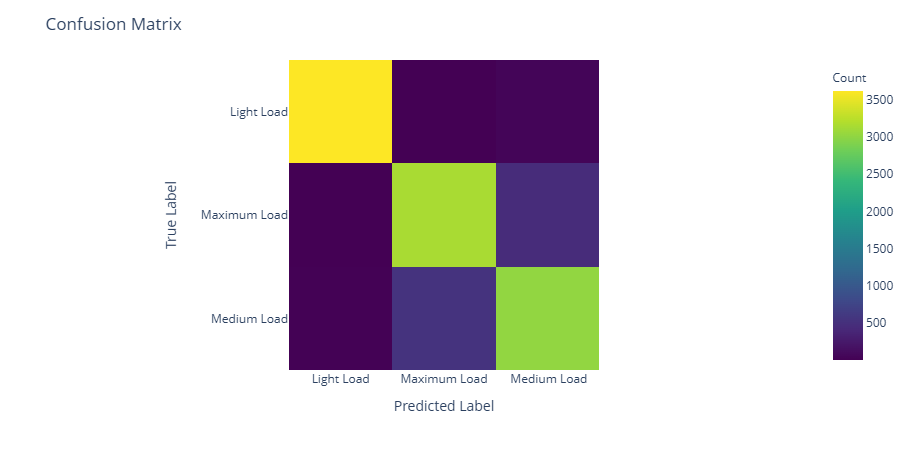

In [60]:
# Print the results
print(f"AUC-ROC: {roc_auc:.4f}")
print('Mean Squared Error:', mse)
print('R-squared:', r2)
print("\nClassification Report:")
print(class_report)
print("Confusion Matrix:")
print(conf_matrix)

# Create a DataFrame for the confusion matrix
classes = ['Light Load','Maximum Load' ,  ' Medium Load']
df_cm = pd.DataFrame(conf_matrix, index=classes, columns=classes)

# Plot the confusion matrix heatmap using Plotly Express
fig = px.imshow(df_cm,
                labels=dict(x="Predicted Label", y="True Label", color="Count"),
                x=classes,
                y=classes,
                color_continuous_scale='Viridis')

# Customize the layout
fig.update_layout(title='Confusion Matrix',
                  xaxis_title='Predicted Label',
                  yaxis_title='True Label')

# Show the plot
fig.show()

# Regression Models

### Feature Engineering

In [61]:
def feature_selection_using_RFR(x,y):
    model = RandomForestRegressor()
    rfe = RFE(model, n_features_to_select=5)  # Choose the number of features to select
    rfe.fit(x, y)

    selected_features = x.columns[rfe.support_]
    importances = np.max(rfe.ranking_) + 1 - rfe.ranking_
    fig = px.bar(x=x.columns, y=importances, labels={'x': 'Feature', 'y': 'Importance'},
                     title='Feature Importances')
    fig.show()
    x = x[selected_features]
    return x,y

In [62]:
# Split the dataset and prepare some lists to store the models
x = df.drop(['Usage_kWh'], axis=1)
y = df.Usage_kWh

In [63]:
# Split the dataset and prepare some lists to store the models
xg = df_aug.drop(['Usage_kWh'], axis=1)
yg = df_aug.Usage_kWh

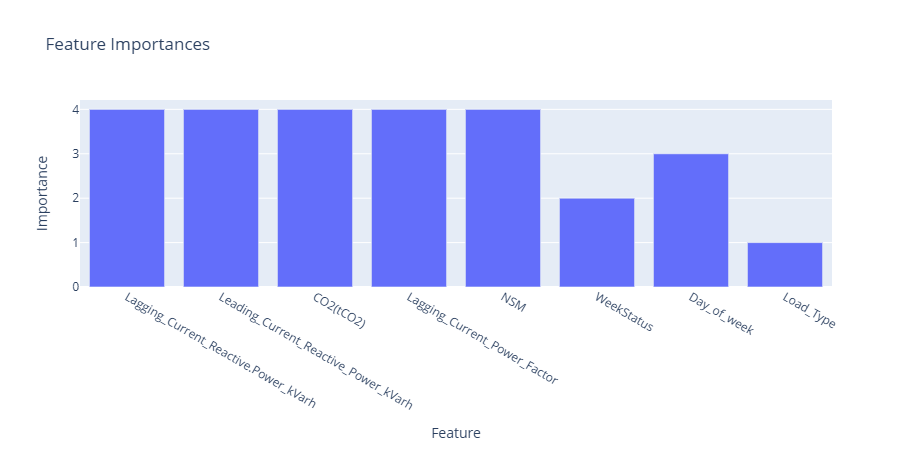

In [64]:
x , y = feature_selection_using_RFR(x,y)

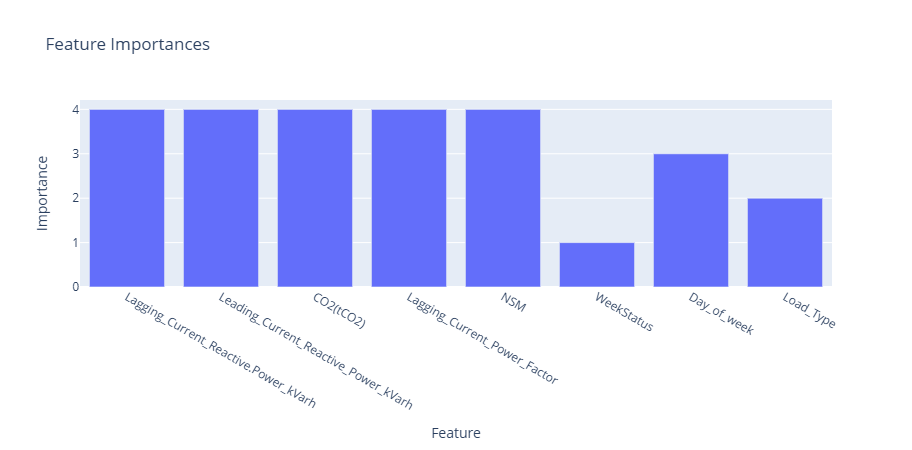

In [65]:
xg , yg = feature_selection_using_RFR(xg,yg)

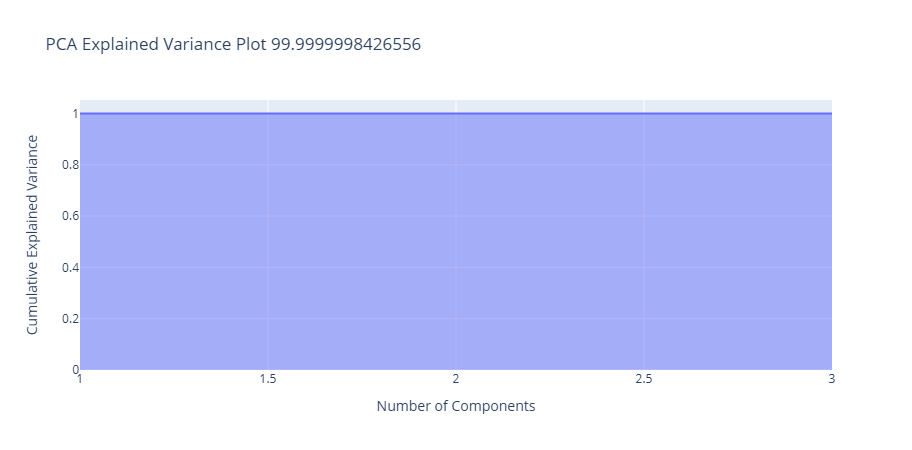

In [66]:
x = dimensionality_reduction_with_pca(x)

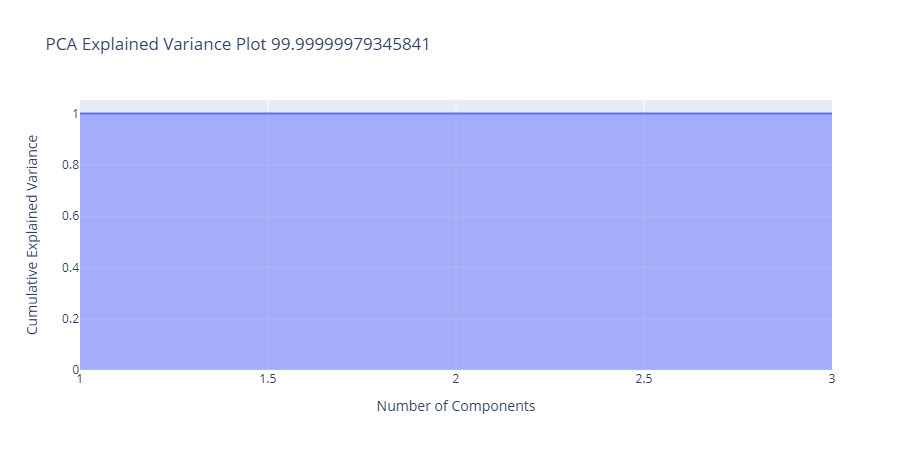

In [67]:
xg = dimensionality_reduction_with_pca(xg)

In [68]:
# Split the dataset and prepare some lists to store the models
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 42) 
xg_train, xg_test, yg_train, yg_test = train_test_split(xg, yg, test_size=0.25, random_state = 42) 

### Model Trainging

In [69]:
#Loop for the training model  
names = [
    "Linear Regression",
    "Ridge Regression",
    "Decision Tree Regression",
    "Random Forest Regression",
    "Gradient Boosting Regression",
    "KNN Regression",
    "Bayesian Ridge Regression",
    "XGBoost Regression"
]
 
reg = [
    LinearRegression(),
    Ridge(alpha=0.5),
    DecisionTreeRegressor(max_depth=5),
    RandomForestRegressor(n_estimators=5,max_depth=5),
    GradientBoostingRegressor(),
    KNeighborsRegressor(n_neighbors=35,leaf_size=50),
    BayesianRidge(),
    xgb.XGBRegressor()
]

In [70]:
def train_reg(x_train, y_train,x_test, y_test):
    scores = []
    for model in tqdm(reg):
        model.fit(x_train, y_train)
        score = model.score(x_test, y_test)
        scores.append(score)
#         print(model)
#         print(score)
    return pd.DataFrame(zip(names,scores), columns=['Regressor', 'Accuracy'])

  0%|          | 0/8 [00:00<?, ?it/s]

                      Regressor  Accuracy
7            XGBoost Regression  0.993900
4  Gradient Boosting Regression  0.975651
3      Random Forest Regression  0.932936
5                KNN Regression  0.925201
2      Decision Tree Regression  0.925054
6     Bayesian Ridge Regression  0.884750
1              Ridge Regression  0.884750
0             Linear Regression  0.884750


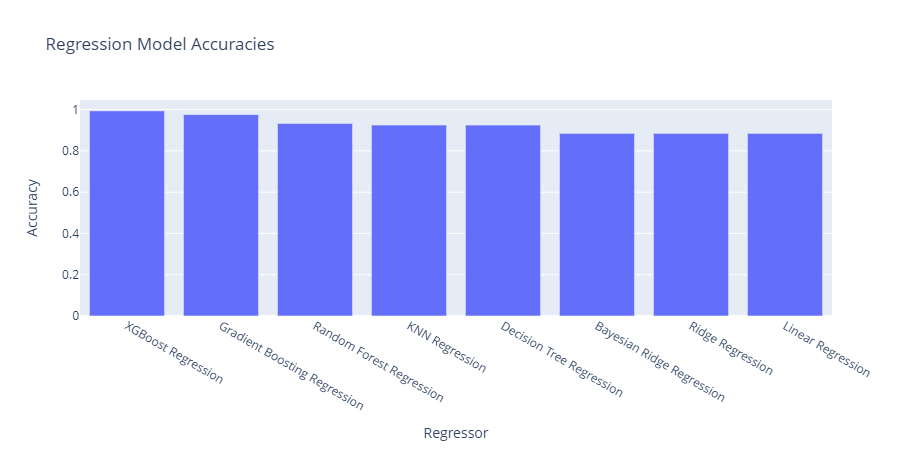

In [71]:
#List the Regressor and their accuracy
scores_df = train_reg(x_train, y_train,x_test, y_test)
scores_df = scores_df.sort_values(by=['Accuracy'], ascending=[False])
print(scores_df)

# Plot the accuracies using Plotly Express
fig = px.bar(scores_df, x='Regressor', y='Accuracy', labels={'Regressor': 'Regressor', 'Accuracy': 'Accuracy'},
             title='Regression Model Accuracies')
fig.update_layout(xaxis_title='Regressor', yaxis_title='Accuracy')
fig.show()

  0%|          | 0/8 [00:00<?, ?it/s]

                      Regressor  Accuracy
7            XGBoost Regression  0.995119
4  Gradient Boosting Regression  0.972734
5                KNN Regression  0.953668
3      Random Forest Regression  0.913537
2      Decision Tree Regression  0.909786
6     Bayesian Ridge Regression  0.873043
1              Ridge Regression  0.873043
0             Linear Regression  0.873043


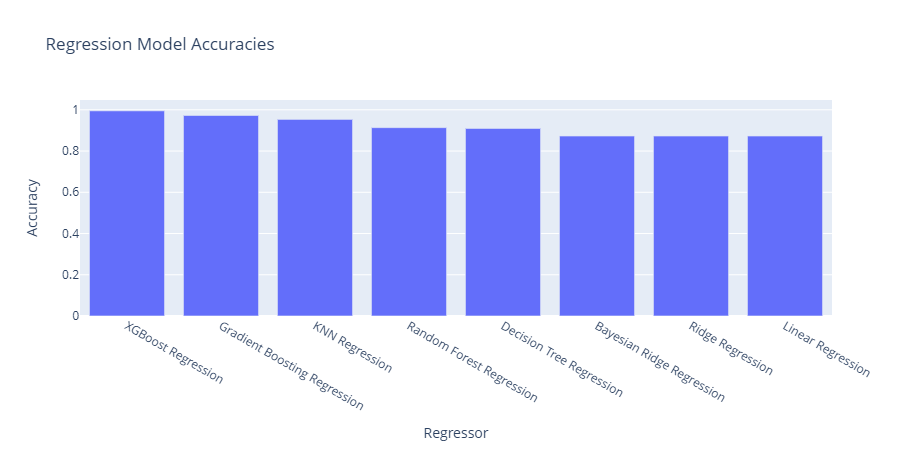

In [72]:
#List the Regressor and their accuracy
scores_df_aug = train_reg(xg_train, yg_train,xg_test, yg_test)
scores_df_aug = scores_df_aug.sort_values(by=['Accuracy'], ascending=[False])
print(scores_df_aug)

# Plot the accuracies using Plotly Express
fig = px.bar(scores_df_aug, x='Regressor', y='Accuracy', labels={'Regressor': 'Regressor', 'Accuracy': 'Accuracy'},
             title='Regression Model Accuracies')
fig.update_layout(xaxis_title='Regressor', yaxis_title='Accuracy')
fig.show()

In [73]:
#Naive grid search implementation
parameters = {'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]}
CBC = xgb.XGBRegressor()
Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 2, n_jobs=-1)
Grid_CBC.fit(xg_train, yg_train)

GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)})

In [74]:
print("Results from Grid Search" )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

Results from Grid Search

 The best estimator across ALL searched params:
 XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=180, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

 The best score across ALL searched params:
 0.9950055125338627

 The best parameters across ALL searched params:
 {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 180}


In [75]:
#This is the classification model with the best parameters
Grid_CBC

GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)})

In [76]:
# Make predictions on the test set
yg_pred = Grid_CBC.predict(xg_test)

### Model Evaluation

In [77]:
def regression_report(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)
    
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("Mean Absolute Error (MAE):", mae)
    print("R-squared (R2) Score:", r2)
    print("Explained Variance Score:", evs)

In [78]:
regression_report(yg_test, yg_pred)

Mean Squared Error (MSE): 4.15807470113739
Root Mean Squared Error (RMSE): 2.0391357731003077
Mean Absolute Error (MAE): 0.9795767392918507
R-squared (R2) Score: 0.9959820268915361
Explained Variance Score: 0.995982247832065


# Clustring Models

In [79]:
encoder = OrdinalEncoder()
df_cluster = df.copy()
df_cluster = df_cluster.drop(['Load_Type'], axis=1)
## Scale Tenure and Monthly Charges
scaler = StandardScaler()
df_cluster[numeric_cols] = scaler.fit_transform(df_cluster[numeric_cols])

#Selecting all variables except tenure and Monthly Charges
df_cluster[df_cluster.columns[~df_cluster.columns.isin(numeric_cols)]] = encoder.fit_transform(df_cluster[df_cluster.columns[~df_cluster.columns.isin(numeric_cols)]])

In [80]:
def optimise_k_means(data, max_k):
    means = []
    inertias = []

    for k in range(1,max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        means.append(k)
        inertias.append(kmeans.inertia_)

    fig = plt.subplots(figsize=(10, 7))
    plt.plot(means, inertias, 'o-', color = 'Blue')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

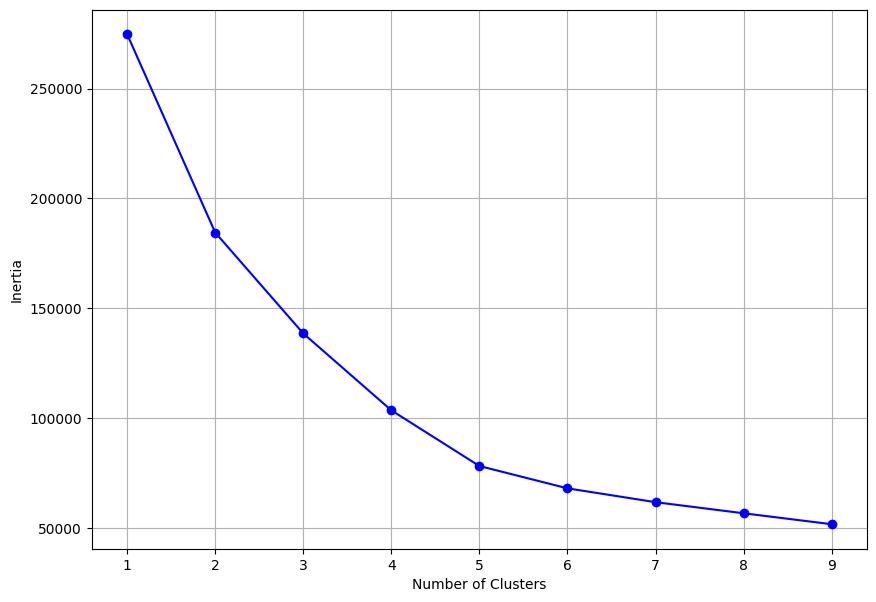

In [81]:
optimise_k_means(df_cluster, 10)

In [82]:
kmeans = KMeans(n_clusters = 4,  random_state=10)
kmeans.fit(df_cluster)
# Save cluster group as a column value in our data_frame
df_cluster['Cluster'] = kmeans.labels_ 

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [83]:
df['Cluster'] = df_cluster['Cluster']

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warn

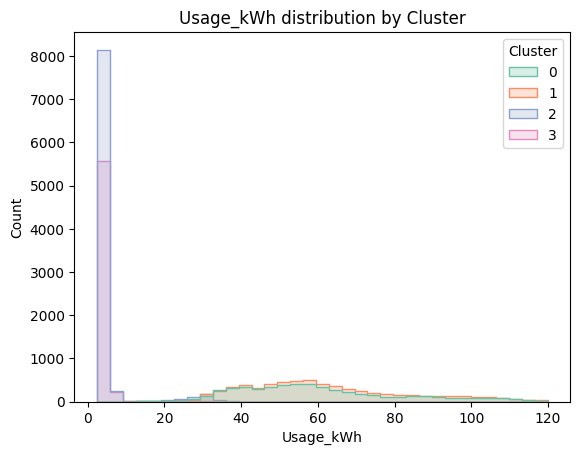

In [84]:
sns.histplot(data=df, x="Usage_kWh", hue="Cluster", element="step", palette="Set2")
plt.title('Usage_kWh distribution by Cluster') 
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warn

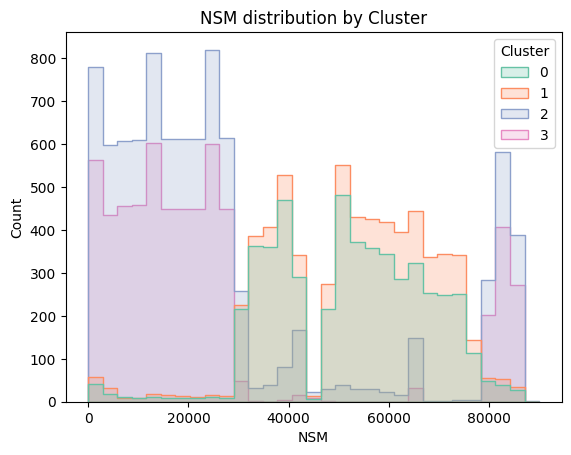

In [85]:
sns.histplot(data=df, x="NSM", hue="Cluster", element="step", palette="Set2")
plt.title('NSM distribution by Cluster') 
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warn

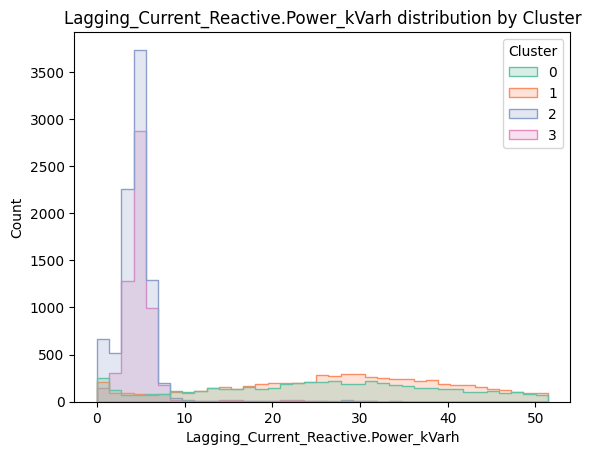

In [86]:
sns.histplot(data=df, x="Lagging_Current_Reactive.Power_kVarh", hue="Cluster", element="step", palette="Set2")
plt.title('Lagging_Current_Reactive.Power_kVarh distribution by Cluster') 
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warn

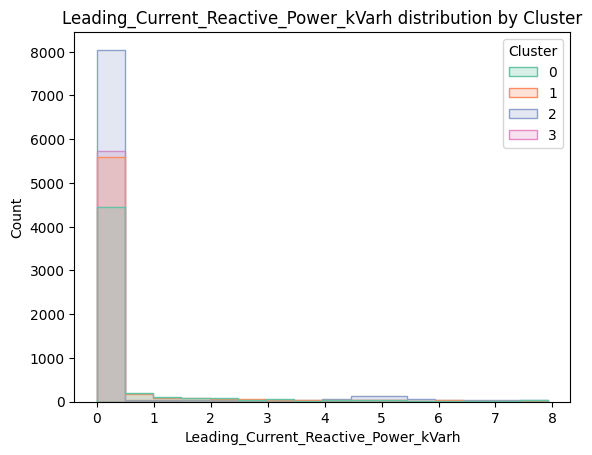

In [87]:
sns.histplot(data=df, x="Leading_Current_Reactive_Power_kVarh", hue="Cluster", element="step", palette="Set2")
plt.title('Leading_Current_Reactive_Power_kVarh distribution by Cluster') 
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warn

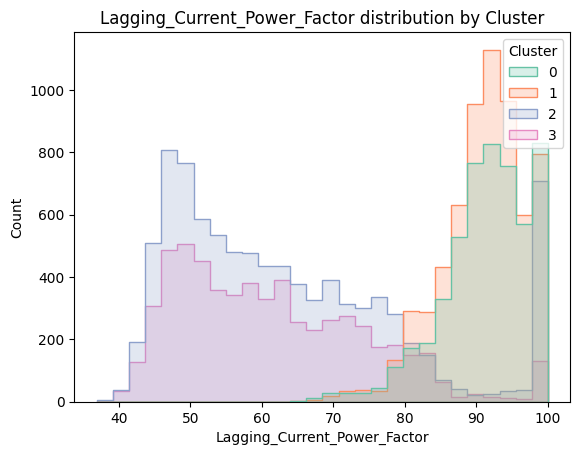

In [88]:
sns.histplot(data=df, x="Lagging_Current_Power_Factor", hue="Cluster", element="step", palette="Set2")
plt.title('Lagging_Current_Power_Factor distribution by Cluster') 
plt.show()

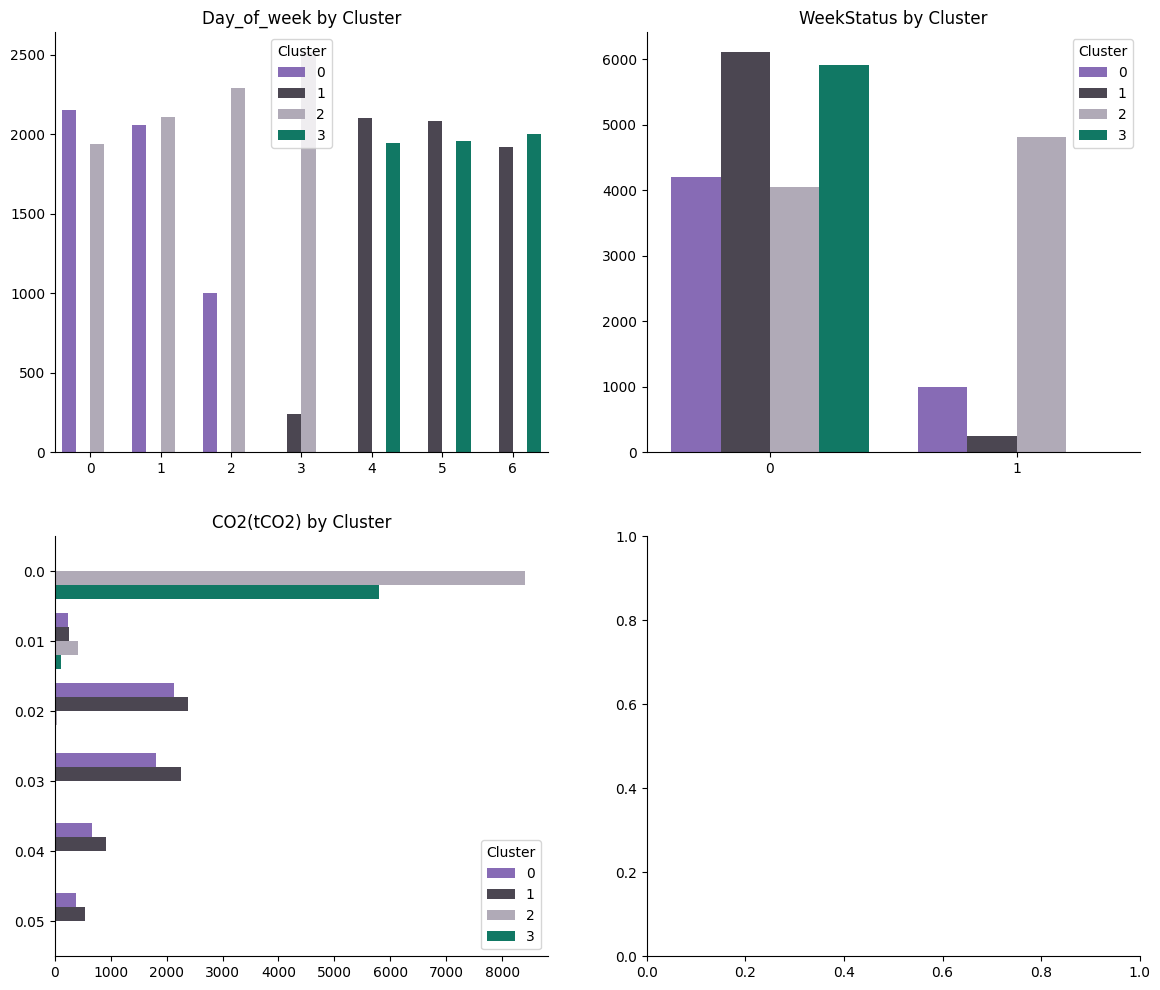

In [91]:
# Gray for No Churn, highlight Churn!
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,12))
sns.despine()
colors = ["#845EC2", "#4B4453", "#B0A8B9","#00896F"]
# Set custom color palette
sns.set_palette(sns.color_palette(colors))
ax = sns.countplot(x="Day_of_week", hue="Cluster", data=df, ax = axes[0,0]).set(title='Day_of_week by Cluster', xlabel=None, ylabel = None)
ax = sns.countplot(x="WeekStatus", hue="Cluster", data=df, ax = axes[0,1]).set(title='WeekStatus by Cluster', xlabel=None, ylabel = None)
ax = sns.countplot(y='CO2(tCO2)', hue="Cluster", data=df, ax = axes[1,0]).set(title='CO2(tCO2) by Cluster', xlabel=None, ylabel = None)
sns.despine() 